In [1]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [2]:
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):   

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
train = pickle.load(open('../data/train.pk', 'rb'))
test = pickle.load(open('../data/test.pk', 'rb'))
dev_test = pickle.load(open('../data/dev_test.pk', 'rb'))

In [4]:
def createset(data_set):
    X = []
    y = []
    for text, label in data_set:
        X.append(text)
        y.append(label)
    return X, y

In [5]:
X, y = createset(train+dev_test)
X_test, y_test = createset(test)

In [6]:
d = {"en":[], "da":[], "de":[], "nn":[], 'nb': []}

for text, label in train:
        d[label].append(text)

In [7]:
distru_language = [len(d["en"]),len(d["nb"]),len(d["de"]),len(d["da"]), len(d['nn'])]
size = sum(distru_language)
size

39983

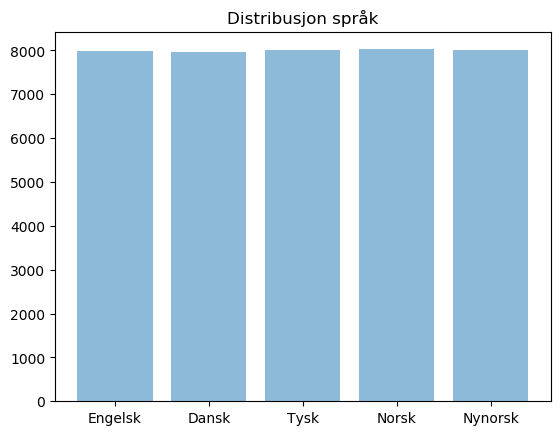

In [8]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Engelsk', 'Dansk', 'Tysk', 'Norsk', 'Nynorsk')
y_pos = np.arange(len(objects))


plt.bar(y_pos, distru_language, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Distribusjon språk')

plt.show()

In [9]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.10, random_state=42)

In [10]:
X_train[0:5]

['Dermed kan det vere vanskeleg å oppfylle lova om å gje barn som treng det nødvendig hjelp og omsorg til rett tid.',
 'Fikk hun for mye ansvar?',
 '"Muslims and Arabs can visit the mosque in a very quiet and normal way without violence, but the Israelis are inciting and provoking," he said.',
 'Det skjedde 26. november.',
 'The technology recognizes new gestures like pressing and holding.']

In [11]:
from warnings import simplefilter
from sklearn.feature_extraction.text import TfidfVectorizer
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression()), ])

In [12]:
pipe = text_clf.fit(X_train, Y_train)

In [13]:
predicted = text_clf.predict(X_validation)

In [14]:
acc = text_clf.score(X_validation, Y_validation)
acc

0.9682080924855492

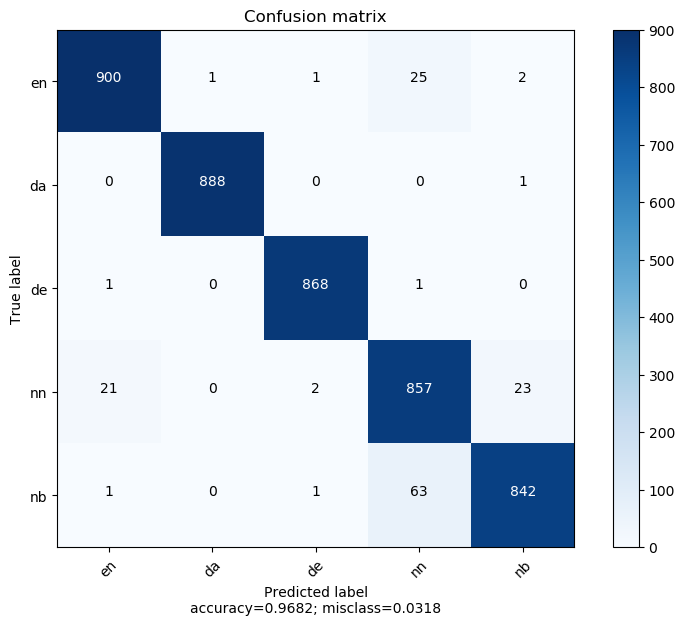

In [15]:
from sklearn.metrics import confusion_matrix
class_names = ['en','da','de','nn','nb']
cm = confusion_matrix(Y_validation, predicted)
plot_confusion_matrix(cm,class_names,normalize=False)

In [16]:
print(classification_report(Y_validation, predicted,target_names=class_names))

              precision    recall  f1-score   support

          en       0.98      0.97      0.97       929
          da       1.00      1.00      1.00       889
          de       1.00      1.00      1.00       870
          nn       0.91      0.95      0.93       903
          nb       0.97      0.93      0.95       907

    accuracy                           0.97      4498
   macro avg       0.97      0.97      0.97      4498
weighted avg       0.97      0.97      0.97      4498



In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

parameters = {
     'tfidf__ngram_range': [(1, 1), (1, 2),(1, 3)],
     'tfidf__binary':[True, False],
     'tfidf__use_idf': (True, False),
     'tfidf__lowercase':(True, False),
     'clf__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

In [19]:
n_iter_search = 30
random_grid_search = RandomizedSearchCV(text_clf,n_jobs=-1, 
                                        param_distributions=parameters, 
                                        n_iter=n_iter_search, 
                                        cv=5, 
                                        iid=False)

In [20]:
%%time
search =random_grid_search.fit(X_train, Y_train)

CPU times: user 32 s, sys: 408 ms, total: 32.4 s
Wall time: 3min 45s


In [21]:
random_grid_search.best_score_

0.9702338499616298

In [22]:
for param_name in sorted(parameters.keys()):
     print("%s: %r" % (param_name, random_grid_search.best_params_[param_name]))

clf__C: 10.0
tfidf__binary: False
tfidf__lowercase: True
tfidf__ngram_range: (1, 1)
tfidf__use_idf: True


In [23]:
final_model = random_grid_search.best_estimator_

In [24]:
final_pred = final_model.predict(X_test)

In [25]:
final_model.score(X_test, y_test)

0.9699819891935161

In [26]:
def check_predicted():
    false_pred=[]
    
    for i in range(len(X_validation)):
        if predicted[i] != Y_validation[i]:
            false_pred.append((X_validation[i],'Predicted: ' + predicted[i], 'Y_true: ' + Y_validation[i]))
    return false_pred
    

In [27]:
false_pred = check_predicted()
print(len(false_pred))
false_pred[:10]

143


[('Deres egen vurdering var en placering i top tre, men det holdt altså ikke stik.',
  'Predicted: nb',
  'Y_true: da'),
 ('Studenten er av opphavleg av utanlandsk opphav.',
  'Predicted: nb',
  'Y_true: nn'),
 ('Dette har ført til omgjering av mellom fem og ti prosent av sakene.',
  'Predicted: nb',
  'Y_true: nn'),
 ('Det sande magiske symbol er et billede som gemmer en indre betydning.',
  'Predicted: nb',
  'Y_true: da'),
 ('I dag takkar han for seg.', 'Predicted: nb', 'Y_true: nn'),
 ('De mente at det var upretensiøst og fint.', 'Predicted: da', 'Y_true: nb'),
 ('- Vi hadde mista butikkane.', 'Predicted: nb', 'Y_true: nn'),
 ('Nordeas økonomer har med bakgrunn i dette nedjustert vekstutsiktene for Spania i 2012 og 2013.',
  'Predicted: da',
  'Y_true: nb'),
 ('Han er en skøn ukompliceret Border Collie.', 'Predicted: nb', 'Y_true: da'),
 ('- Fyrst og fremst er de vel konservative?', 'Predicted: nb', 'Y_true: nn')]

In [28]:
final_model.predict(["Det er ein lovfesta rett å få opplæring i og tilgang til båe skriftspråka"])

array(['nn'], dtype='<U2')

In [29]:
final_model.predict(['Me feirar i år 200 år sidan grunnlova vart til i 1814'])

array(['nn'], dtype='<U2')

In [30]:
final_model.predict(['Desse to skriftspråka'])

array(['en'], dtype='<U2')

In [31]:
final_model.predict(['høyra den lokale dialekten '])

array(['nn'], dtype='<U2')

In [32]:
final_model.predict(['kjernen i granskingen er hvorvidt Trump har misbruk'])

array(['nb'], dtype='<U2')

In [33]:
final_model.predict(['De TV-sendte høringene'])

array(['nb'], dtype='<U2')

In [34]:
final_model.predict(['Korkje'])

array(['nn'], dtype='<U2')